In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from random import randint

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.utils import make_grid

In [7]:
# 데이터 다운로드
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

# 압축 파일 해제
!unzip -qq 'tiny-imagenet-200.zip'

# 파일 경로
DATA_DIR = 'tiny-imagenet-200'

# train & val 파일 경로
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VALID_DIR = os.path.join(DATA_DIR, 'val')

--2024-08-25 15:44:07--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs231n.stanford.edu/tiny-imagenet-200.zip [following]
--2024-08-25 15:44:07--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  6.89MB/s    in 22s     

2024-08-25 15:44:29 (10.9 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [8]:
VALID_DIR = '/content/tiny-imagenet-200/val' # 검증 데이터셋(val) 디렉토리 경로를 설정

val_img_dir = os.path.join(VALID_DIR, 'images') # 검증 데이터셋의 이미지들이 저장된 디렉토리 경로를 설정

fp = open(os.path.join(VALID_DIR, 'val_annotations.txt'), 'r') # val annotations text file 열기 & 읽기

data = fp.readlines() # 파일의 모든 줄을 읽어서 리스트로 저장

val_img_dict = {} # 검증 이미지와 해당 레이블을 저장할 빈 딕셔너리 생성

for line in data:
    words = line.split('\t') # 각 줄을 탭 문자('\t')로 분리하여 이미지 파일 이름과 레이블을 분리
    val_img_dict[words[0]] = words[1] # 이미지 파일 이름을 키로, 레이블을 값으로 딕셔너리에 저장

fp.close() # 파일을 닫음

{k: val_img_dict[k] for k in list(val_img_dict)[:10]} # val_img_dict 딕셔너리에서 첫 10개의 키-값 쌍을 가져와 출력


{'val_0.JPEG': 'n03444034',
 'val_1.JPEG': 'n04067472',
 'val_2.JPEG': 'n04070727',
 'val_3.JPEG': 'n02808440',
 'val_4.JPEG': 'n02808440',
 'val_5.JPEG': 'n04399382',
 'val_6.JPEG': 'n04179913',
 'val_7.JPEG': 'n02823428',
 'val_8.JPEG': 'n04146614',
 'val_9.JPEG': 'n02226429'}

In [9]:
# train 파일 같이 변경

for img, folder in val_img_dict.items():
    newpath = (os.path.join(val_img_dir, folder))
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    if os.path.exists(os.path.join(val_img_dir, img)):
        os.rename(os.path.join(val_img_dir, img), os.path.join(newpath, img))

In [10]:
IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',
]


def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)


def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx


def make_dataset(dir, class_to_idx):
    images = []
    dir = os.path.expanduser(dir)
    for target in sorted(os.listdir(dir)):
        d = os.path.join(dir, target)
        if not os.path.isdir(d):
            continue

        for root, _, fnames in sorted(os.walk(d)):
            for fname in sorted(fnames):
                if is_image_file(fname):
                    path = os.path.join(root, fname)
                    item = (path, class_to_idx[target])
                    images.append(item)

    return images


def pil_loader(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')


class ImageFolder(Dataset):

    def __init__(self, root, transform=None):
        classes, class_to_idx = find_classes(root)
        imgs = make_dataset(root, class_to_idx)

        self.root = root
        self.imgs = imgs
        self.classes = classes
        self.class_to_idx = class_to_idx
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):

        path, target = self.imgs[index]
        img = pil_loader(path)
        if self.transform is not None:
            img = self.transform(img)

        return img, target

In [11]:
transform = T.Compose([
                T.Resize(224),
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
])

In [12]:
train_set = ImageFolder('/content/tiny-imagenet-200/train', transform=transform)
val_set = ImageFolder('/content/tiny-imagenet-200/val/images', transform=transform)

train_loader = DataLoader(train_set, batch_size = 16, shuffle = True)
val_loader = DataLoader(val_set, batch_size = 16, shuffle = False)

In [13]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_batch(dataloader):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    imshow(make_grid(images))

def show_image(dataloader):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    random_num = randint(0, len(images)-1)
    imshow(images[random_num])
    label = labels[random_num]
    print(f'Label: {label}, Shape: {images[random_num].shape}')

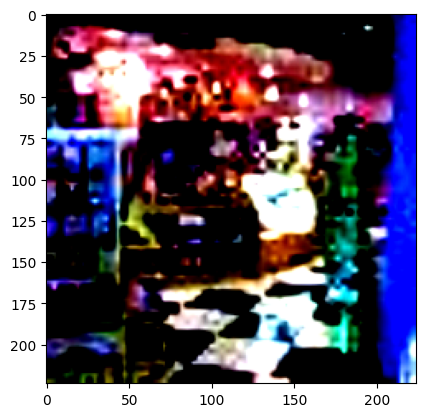

Label: 93, Shape: torch.Size([3, 224, 224])


In [14]:
# Example usage
show_image(train_loader)

In [15]:
# LeNet5

class LeNet5(nn.Module):

    def __init__(self, channels, n_classes):
        super(LeNet5, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120 * 49 * 49, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x) # B, 120, 49, 49
        x = x.view(-1, 120 * 49 * 49)
        x = self.classifier(x)
        return x

In [16]:
# 모델 확인

model_L = LeNet5(channels=3, n_classes=200)

x = torch.randn(1,3,224,224)
y = model_L(x)
y.shape

torch.Size([1, 200])

In [17]:
# AlexNet

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet,self).__init__()

        # Conv layer
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(256, 384, 3, 1, 1),
            nn.ReLU(),

            nn.Conv2d(384, 384, 3, 1, 1),
            nn.ReLU(),

            nn.Conv2d(384, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(3, 2),
        )

        # fc layer
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=(256 * 5 * 5), out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=num_classes),
        )


    def forward(self,x):
        x = self.feature_extractor(x)
        x = x.view(-1, 256 * 5 * 5)
        x = self.classifier(x)
        return x

In [18]:
# 모델 확인

model_A = AlexNet(num_classes=200)

x = torch.randn(1,3,224,224)
y = model_A(x)
y.shape

torch.Size([1, 200])

In [19]:
# VGG

# int : output chnnels after conv layer
# 'M' : max pooling layer

VGG_types = {
    'VGG11' : [64, 'M', 128, 'M', 256, 256, 'M', 512,512, 'M',512,512,'M'],
    'VGG13' : [64,64, 'M', 128, 128, 'M', 256, 256, 'M', 512,512, 'M', 512,512,'M'],
    'VGG16' : [64,64, 'M', 128, 128, 'M', 256, 256,256, 'M', 512,512,512, 'M',512,512,512,'M']
}


class VGGnet(nn.Module):
    def __init__(self, model, in_channels=3, num_classes=200):
        super(VGGnet,self).__init__()
        self.in_channels = in_channels

        # create conv_layers corresponding to VGG type
        self.conv_layers = self.create_conv_layers(VGG_types[model])

        self.fcs = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )


    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 512 * 7 * 7)
        x = self.fcs(x)
        return x


    # define a function to create conv layer taken the key of VGG_type dict
    def create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels # 3

        for x in architecture:
            if type(x) == int: # int means conv layer
                out_channels = x

                layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                     kernel_size=(3,3), stride=(1,1), padding=(1,1)),
                           nn.BatchNorm2d(x),
                           nn.ReLU()]
                in_channels = x
            elif x == 'M':
                layers += [nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))]

        return nn.Sequential(*layers)

In [20]:
# 모델 확인

model_V = VGGnet('VGG16', in_channels=3, num_classes=200)

x = torch.randn(1,3,224,224)
y = model_V(x)
y.shape

torch.Size([1, 200])

In [21]:
# GoogLeNet

class GoogLeNet(nn.Module):
    def __init__(self,aux_logits=True, num_classes=10):
        super(GoogLeNet, self).__init__()
        assert aux_logits == True or aux_logits == False
        self.aux_logits = aux_logits

        # conv_block takes in_channels, out_channels, kernel_size, stride, padding
        # Inception block takes out1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool

        self.conv1 = conv_block(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(3, 2, 1)
        self.conv2 = conv_block(64, 192, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, 2, 1)
        self.inception3a = Inception_block(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception_block(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, 2, 1)
        self.inception4a = Inception_block(480, 192, 96, 208, 16, 48, 64)

        # auxiliary classifier

        self.inception4b = Inception_block(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception_block(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception_block(512, 112, 144, 288, 32, 64, 64)

        # auxiliary classifier

        self.inception4e = Inception_block(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(3, 2, 1)
        self.inception5a = Inception_block(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception_block(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(7, 1)
        self.dropout = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(1024, num_classes)

        if self.aux_logits:
            self.aux1 = InceptionAux(512, num_classes)
            self.aux2 = InceptionAux(528, num_classes)
        else:
            self.aux1 = self.aux2 = None


    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)
        x = self.inception4a(x)

        if self.aux_logits and self.training:
            aux1 = self.aux1(x)

        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)

        if self.aux_logits and self.training:
            aux2 = self.aux2(x)

        x = self.inception4e(x)
        x = self.maxpool4(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)

        x = x.view(x.shape[0], -1)

        x = self.dropout(x)
        x = self.fc1(x)

        if self.aux_logits and self.training:
            return x, aux1, aux2
        else:
            return x



class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(conv_block, self).__init__()

        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, **kwargs),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.conv_layer(x)


class Inception_block(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool):
        super(Inception_block, self).__init__()

        self.branch1 = conv_block(in_channels, out_1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            conv_block(in_channels, red_3x3, kernel_size=1),
            conv_block(red_3x3, out_3x3, kernel_size=3, padding=1),
        )

        self.branch3 = nn.Sequential(
            conv_block(in_channels, red_5x5, kernel_size=1),
            conv_block(red_5x5, out_5x5, kernel_size=5, padding=2),
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            conv_block(in_channels, out_1x1pool, kernel_size=1)
        )

    def forward(self, x):
        # 0차원은 batch이므로 1차원인 filter 수를 기준으로 각 branch의 출력값을 묶어줍니다.
        x = torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1)
        return x

# auxiliary classifier의 loss는 0.3이 곱해지고, 최종 loss에 추가합니다. 정규화 효과가 있습니다.
class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()

        self.conv = nn.Sequential(
            nn.AvgPool2d(kernel_size=5, stride=3),
            conv_block(in_channels, 128, kernel_size=1),
        )

        self.fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1024, num_classes),
        )

    def forward(self,x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [22]:
# 모델 확인

model_G = GoogLeNet(aux_logits=True, num_classes=200)

x = torch.randn(1,3,224,224)
y = model_G(x)

# 결과 3개(auxiliary classifier 2개)
print(y[0].shape)
print(y[1].shape)
print(y[2].shape)

torch.Size([1, 200])
torch.Size([1, 200])
torch.Size([1, 200])


In [23]:
# BasicBlock 정의 (ResNet-18, ResNet-34에서 사용)
class BasicBlock(nn.Module):
    expansion = 1  # 출력 채널 수의 확장 비율 (BasicBlock에서는 1로 고정)

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        # 첫 번째 3x3 합성곱 레이어
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)  # 첫 번째 BatchNorm 레이어
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)  # 두 번째 3x3 합성곱 레이어
        self.bn2 = nn.BatchNorm2d(planes)  # 두 번째 BatchNorm 레이어
        self.downsample = downsample  # 입력과 출력의 크기가 다를 때 사용하는 다운샘플링 레이어
        self.relu = nn.ReLU(inplace=True)  # 활성화 함수 ReLU
        self.stride = stride  # 블록의 스트라이드 설정

    def forward(self, x):
        identity = x  # 잔차 연결을 위해 입력을 저장

        out = self.conv1(x)  # 첫 번째 합성곱 연산
        out = self.bn1(out)  # BatchNorm 연산
        out = self.relu(out)  # ReLU 활성화

        out = self.conv2(out)  # 두 번째 합성곱 연산
        out = self.bn2(out)  # BatchNorm 연산

        if self.downsample is not None:  # 다운샘플링이 필요한 경우
            identity = self.downsample(x)  # 입력을 다운샘플링

        out += identity  # 입력을 더함 (잔차 연결)
        out = self.relu(out)  # ReLU 활성화

        return out  # 출력 반환

# Bottleneck 블록 정의 (ResNet-50, ResNet-101, ResNet-152에서 사용)
class Bottleneck(nn.Module):
    expansion = 4  # 출력 채널 수의 확장 비율 (Bottleneck에서는 4로 설정)
    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1)  # 1x1 합성곱 레이어 (차원 축소)
        self.bn1 = nn.BatchNorm2d(planes)  # 첫 번째 BatchNorm 레이어
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)  # 3x3 합성곱 레이어
        self.bn2 = nn.BatchNorm2d(planes)  # 두 번째 BatchNorm 레이어
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1)  # 1x1 합성곱 레이어 (차원 확장)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)  # 세 번째 BatchNorm 레이어
        self.downsample = downsample  # 입력과 출력의 크기가 다를 때 사용하는 다운샘플링 레이어
        self.relu = nn.ReLU()  # 활성화 함수 ReLU
        self.stride = stride  # 블록의 스트라이드 설정

    def forward(self, x):
        identity = x  # 잔차 연결을 위해 입력을 저장

        out = self.conv1(x)  # 첫 번째 1x1 합성곱 연산
        out = self.bn1(out)  # 첫 번째 BatchNorm 연산
        out = self.relu(out)  # ReLU 활성화

        out = self.conv2(out)  # 3x3 합성곱 연산
        out = self.bn2(out)  # 두 번째 BatchNorm 연산
        out = self.relu(out)  # ReLU 활성화

        out = self.conv3(out)  # 두 번째 1x1 합성곱 연산
        out = self.bn3(out)  # 세 번째 BatchNorm 연산

        if self.downsample is not None:  # 다운샘플링이 필요한 경우
            identity = self.downsample(x)  # 입력을 다운샘플링

        out += identity  # 입력을 더함 (잔차 연결)
        out = self.relu(out)  # ReLU 활성화

        return out  # 출력 반환

# ResNet 클래스 정의
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_planes = 64  # 입력 채널 수

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)  # 첫 번째 7x7 합성곱 레이어
        self.bn1 = nn.BatchNorm2d(64)  # BatchNorm 레이어
        self.relu = nn.ReLU()  # ReLU 활성화 함수
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # MaxPool 레이어

        self.layer1 = self._make_layer(block, 64, layers[0])  # 첫 번째 레이어 (ResNet 블록)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)  # 두 번째 레이어
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)  # 세 번째 레이어
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)  # 네 번째 레이어
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Adaptive Average Pooling 레이어
        self.fc = nn.Linear(512 * block.expansion, num_classes)  # Fully Connected 레이어 (출력)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:  # 입력과 출력의 크기가 다를 경우
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes * block.expansion, kernel_size=1, stride=stride),  # 1x1 합성곱
                nn.BatchNorm2d(planes * block.expansion),  # BatchNorm 레이어
            )

        layers = []
        layers.append(block(self.in_planes, planes, stride, downsample))  # 첫 번째 블록 추가
        self.in_planes = planes * block.expansion  # 다음 블록의 입력 채널 설정
        for _ in range(1, blocks):
            layers.append(block(self.in_planes, planes))  # 나머지 블록 추가

        return nn.Sequential(*layers)  # 블록들을 시퀀스로 반환

    def forward(self, x):
        x = self.conv1(x)  # 첫 번째 합성곱 연산
        x = self.bn1(x)  # BatchNorm 연산
        x = self.relu(x)  # ReLU 활성화
        x = self.maxpool(x)  # MaxPooling 연산

        x = self.layer1(x)  # 첫 번째 레이어 연산
        x = self.layer2(x)  # 두 번째 레이어 연산
        x = self.layer3(x)  # 세 번째 레이어 연산
        x = self.layer4(x)  # 네 번째 레이어 연산

        x = self.avgpool(x)  # Adaptive Average Pooling
        x = torch.flatten(x, 1)  # 1차원으로 펼침
        x = self.fc(x)  # Fully Connected Layer

        return x  # 최종 출력 반환

# ResNet-50 모델 정의
def ResNet50(num_classes=1000):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes)  # ResNet-50 생성

# 모델 생성
model = ResNet50(num_classes=1000)


In [24]:
model_R = ResNet50(num_classes=200)

x = torch.randn(1,3,224,224)
y = model_R(x)
y.shape

torch.Size([1, 200])

In [25]:
from einops import rearrange

# Patch embedding
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Linear(in_channels * patch_size * patch_size, embed_dim)

    def forward(self, x):
        # x shape: (batch_size, in_channels, img_size, img_size)
        # 이미지를 패치로 나누고 (H, W)를 (num_patches, patch_size*patch_size*in_channels)로 변환
        x = rearrange(x, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=self.patch_size, p2=self.patch_size)
        # 각 패치를 임베딩 벡터로 변환
        x = self.proj(x)  # (batch_size, num_patches, embed_dim)
        return x

# Multi-Head Self-Attention
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x)  # (B, N, 3 * embed_dim)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale  # Scaled Dot-Product Attention
        attn = attn.softmax(dim=-1)

        out = attn @ v  # (B, num_heads, N, head_dim)
        out = out.transpose(1, 2).reshape(B, N, C)
        out = self.proj(out)  # 최종 출력: (B, N, embed_dim)
        return out

# Transformer 블록 모듈
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, int(embed_dim * mlp_ratio)),
            nn.GELU(),
            nn.Linear(int(embed_dim * mlp_ratio), embed_dim),
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # 첫 번째 잔차 연결 및 LayerNorm 후 Attention 적용
        x = x + self.dropout(self.attn(self.norm1(x)))
        # 두 번째 잔차 연결 및 LayerNorm 후 MLP 적용
        x = x + self.dropout(self.mlp(self.norm2(x)))
        return x

# Vision Transformer (ViT) 모델
class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, num_classes=1000, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))  # 클래스 토큰
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.patch_embed.num_patches, embed_dim))  # 위치 임베딩
        self.pos_drop = nn.Dropout(p=dropout)

        # 여러 Transformer 블록을 쌓은 인코더
        self.transformer_blocks = nn.Sequential(
            *[TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout) for _ in range(depth)]
        )
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)  # 클래스 예측을 위한 헤드

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)  # 패치 임베딩 생성: (B, num_patches, embed_dim)

        cls_tokens = self.cls_token.expand(B, -1, -1)  # 클래스 토큰 확장: (B, 1, embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)  # 클래스 토큰과 패치 임베딩 결합: (B, 1 + num_patches, embed_dim)
        x = x + self.pos_embed  # 위치 임베딩 추가
        x = self.pos_drop(x)

        x = self.transformer_blocks(x)  # Transformer 인코더 통과
        x = self.norm(x)

        cls_output = x[:, 0]  # 클래스 토큰만 선택
        x = self.head(cls_output)  # 최종 예측: (B, num_classes)
        return x


ModuleNotFoundError: No module named 'einops'

In [ ]:
model_vi = VisionTransformer(num_classes=200)

x = torch.randn(1,3,224,224)
y = model_vi(x)
y.shape

In [26]:
# hyper parameter

num_epochs = 5
learning_rate = 0.001

# if gpu is to be used

use_cuda = torch.cuda.is_available()
print("use_cuda : ", use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")

use_cuda :  False


In [ ]:
# model
model = model_V.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.type(torch.LongTensor)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
        loss.backward()
        optimizer.step()
        if (batch_idx + 1) % 30 == 0:
            print("Train Epoch:{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    train_loss /= len(train_loader.dataset)
    print("\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
                train_loss, correct, len(train_loader.dataset), 100. * correct / len(train_loader.dataset)))
    print('='*50)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print("\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
                test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
        print('='*50)

In [ ]:
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, val_loader)

Train Epoch:1 [464/100000 (0%)]	Loss: 5.244372
Train Epoch:1 [944/100000 (1%)]	Loss: 5.306872
Train Epoch:1 [1424/100000 (1%)]	Loss: 5.306872
Train Epoch:1 [1904/100000 (2%)]	Loss: 5.306872
Train Epoch:1 [2384/100000 (2%)]	Loss: 5.306872
Train Epoch:1 [2864/100000 (3%)]	Loss: 5.306872
Train Epoch:1 [3344/100000 (3%)]	Loss: 5.306872
Train Epoch:1 [3824/100000 (4%)]	Loss: 5.306872
Train Epoch:1 [4304/100000 (4%)]	Loss: 5.306872
Train Epoch:1 [4784/100000 (5%)]	Loss: 5.306872
Train Epoch:1 [5264/100000 (5%)]	Loss: 5.306872
Train Epoch:1 [5744/100000 (6%)]	Loss: 5.306872
Train Epoch:1 [6224/100000 (6%)]	Loss: 5.306872


KeyboardInterrupt: 

# 손 숫자 이미지 분류 실습
### (https://www.kaggle.com/datasets/muhammadkhalid/sign-language-for-numbers)

# 1. 데이터 다운로드

In [ ]:
# 압축 해제
!unzip archive.zip

Archive:  archive.zip
  inflating: Sign Language for Numbers/0/zero_1.jpg  
  inflating: Sign Language for Numbers/0/zero_10.jpg  
  inflating: Sign Language for Numbers/0/zero_100.jpg  
  inflating: Sign Language for Numbers/0/zero_1000.jpg  
  inflating: Sign Language for Numbers/0/zero_1001.jpg  
  inflating: Sign Language for Numbers/0/zero_1002.jpg  
  inflating: Sign Language for Numbers/0/zero_1003.jpg  
  inflating: Sign Language for Numbers/0/zero_1004.jpg  
  inflating: Sign Language for Numbers/0/zero_1005.jpg  
  inflating: Sign Language for Numbers/0/zero_1006.jpg  
  inflating: Sign Language for Numbers/0/zero_1007.jpg  
  inflating: Sign Language for Numbers/0/zero_1008.jpg  
  inflating: Sign Language for Numbers/0/zero_1009.jpg  
  inflating: Sign Language for Numbers/0/zero_101.jpg  
  inflating: Sign Language for Numbers/0/zero_1010.jpg  
  inflating: Sign Language for Numbers/0/zero_1011.jpg  
  inflating: Sign Language for Numbers/0/zero_1012.jpg  
  inflating: Sig

# 2. Dataset + DataLoader
## 2-1. ImageFolder -> Dataset 구성 + DataLoader

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
from timm import create_model
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np


# 데이터 경로 설정
data_dir = '/raid/lee/workspace/Sign Language for Numbers'

# 이미지 전처리 및 데이터 변환 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 데이터셋 로드
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# unknown 클래스의 인덱스 제거
unknown_index = dataset.class_to_idx['unknown']
filtered_indices = [i for i, (_, label) in enumerate(dataset) if label != unknown_index]
filtered_dataset = torch.utils.data.Subset(dataset, filtered_indices)

# 데이터셋을 train/val/test로 분할
train_size = int(0.7 * len(filtered_dataset))
val_size = int(0.15 * len(filtered_dataset))
test_size = len(filtered_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(filtered_dataset, [train_size, val_size, test_size])

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

/raid/lee/anaconda3/envs/2024/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/raid/lee/anaconda3/envs/2024/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## 2-2. Custom Dataset 구성 + DataLoader

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from timm import create_model
from tqdm import tqdm
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np


# Custom Dataset
class SignLanguageDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # 클래스 이름을 가져오고, 'unknown'을 제외합니다.
        self.class_names = sorted([d for d in os.listdir(root_dir) if d != 'unknown'])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.class_names)}

        # 각 이미지의 경로와 라벨을 리스트로 만듭니다.
        for cls_name in self.class_names:
            cls_dir = os.path.join(root_dir, cls_name)
            for image_name in os.listdir(cls_dir):
                image_path = os.path.join(cls_dir, image_name)
                self.image_paths.append(image_path)
                self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        # 이미지를 로드하고 전처리합니다.
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# 데이터 경로 설정
data_dir = '/raid/lee/workspace/Sign Language for Numbers'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = SignLanguageDataset(root_dir=data_dir, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = int(0.10 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# 3. TIMM을 통해 Pre-trained ViT 사용

In [ ]:
# TIMM을 사용해 ViT 모델 생성 (pre-trained weights 사용)
model = create_model('vit_base_patch16_224', pretrained=True, num_classes=10)

# 모델의 분류기 레이어만 학습하도록 설정
for param in model.parameters():
    param.requires_grad = False

# head 레이어의 파라미터만 학습 가능하게 설정
for param in model.head.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

# 3-1. layer check

In [27]:
for name, param in model.named_parameters():
    print(name)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.conv1.bias
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.conv3.bias
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.0.bias
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.conv1.bias
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.conv3.bias
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.conv1.bias
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.conv3.bias
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.conv1.bias
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.conv3.bias
layer2.0.bn3.

# 4. loss & optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 5. train & Val

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # tqdm으로 진행 상태 표시
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

        for inputs, labels in train_loader_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            train_loader_tqdm.set_postfix(loss=(running_loss / (total // 32)), accuracy=100.0 * correct / total)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100.0 * correct / total

        # Validation Phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        best_val_acc = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100.0 * correct / total

        print(f"Epoch {epoch+1}/{num_epochs}.. "
              f"Train Loss: {epoch_loss:.4f}.. Train Acc: {epoch_acc:.2f}%.. "
              f"Val Loss: {val_loss:.4f}.. Val Acc: {val_acc:.2f}%")

        # 최적의 가중치 저장
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_vit_model.pth')
        if val_acc > best_val_acc:
            bes_val_acc = val_acc


    print("Training complete. Best validation loss:", best_val_loss, val_acc)

# 5-1. start

In [ ]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10:   1%|  | 5/375 [00:02<02:42,  2.28batch/s, accuracy=25.6, loss=2.04]


KeyboardInterrupt: 

# 6. 학습한 weight를 통해 test 결과 확인

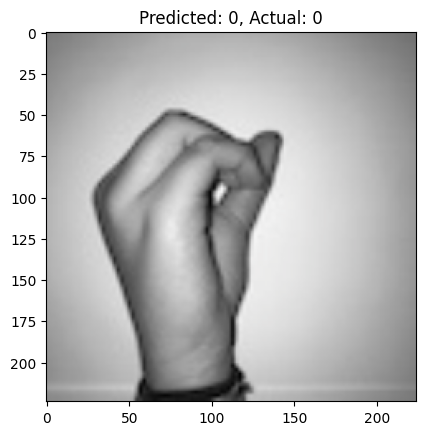

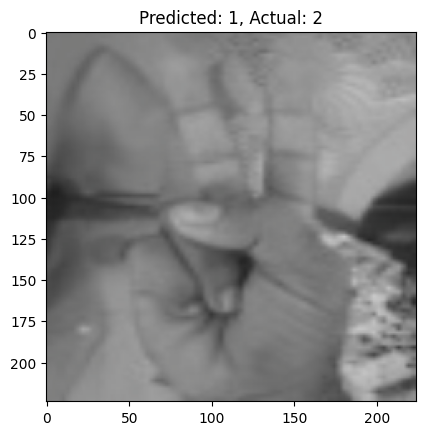

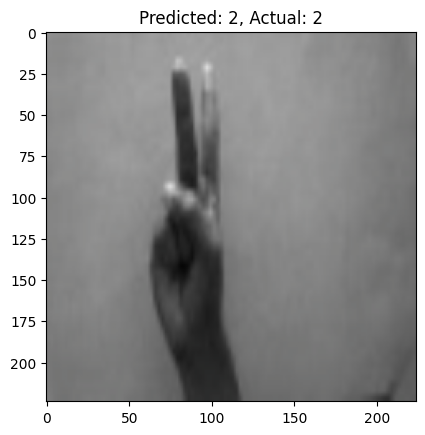

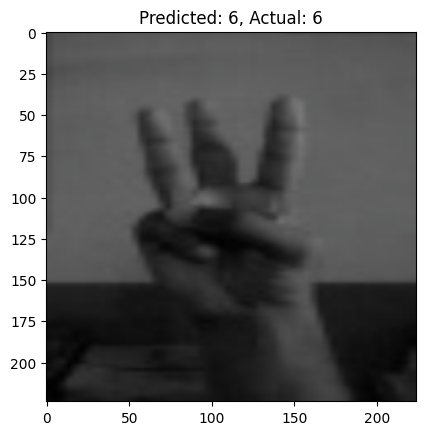

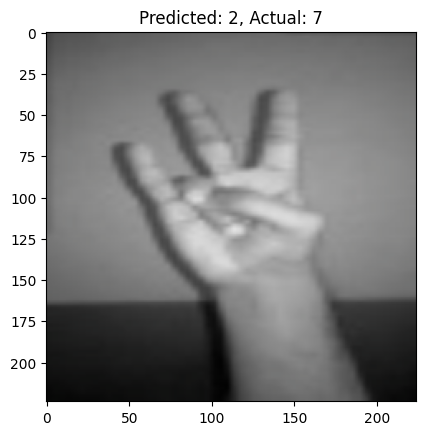

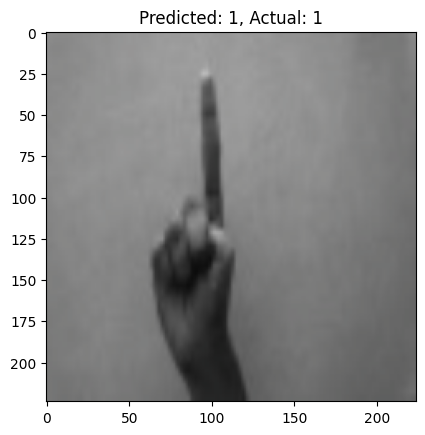

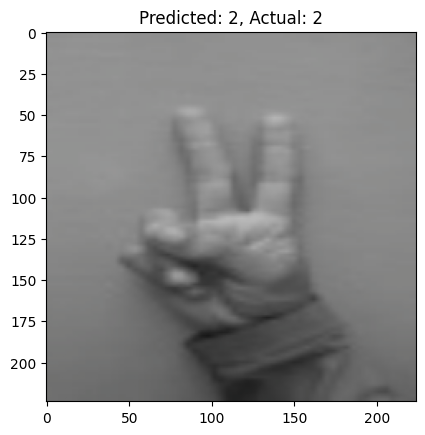

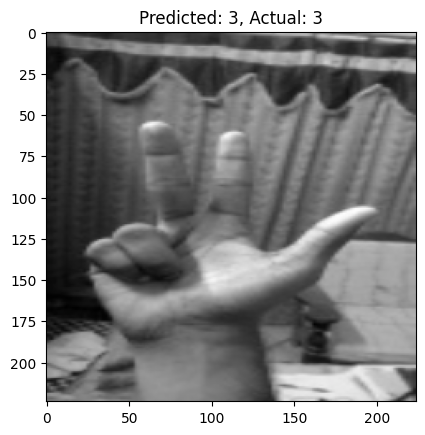

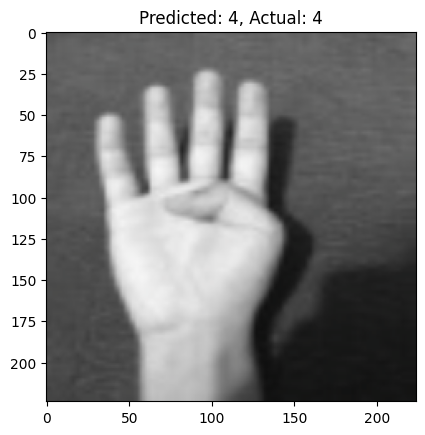

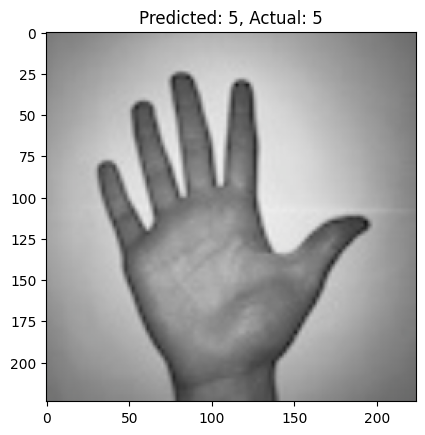

Test Accuracy: 89.11%


In [ ]:
# Unnormalize 함수 정의
unnormalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

def imshow(img, title=None):
    img = unnormalize(img)  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.show()


def test_model_with_visualization(model, test_loader, class_names, num_images=10):
    model.eval()
    correct = 0
    total = 0
    images_shown = 0  # 시각화한 이미지의 개수를 추적

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # 이미지를 시각화하고 예측 결과를 표시
            for i in range(len(inputs)):
                if images_shown < num_images:  # 최대 num_images개의 이미지만 시각화
                    imshow(inputs[i].cpu(), title=f'Predicted: {class_names[predicted[i]]}, Actual: {class_names[labels[i]]}')
                    images_shown += 1

    print(f"Test Accuracy: {100.0 * correct / total:.2f}%")

# 최적 가중치 로드 후 테스트
model.load_state_dict(torch.load('best_vit_model.pth'))

# 클래스 이름 정의 (SignLanguageDataset에서 가져옴)
class_names = dataset.class_names

# 테스트 이미지와 결과 시각화 (최대 10개 이미지 표시, 전체 데이터 성능 평가)
test_model_with_visualization(model, test_loader, class_names, num_images=10)
